***Mount Data from Drive***

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


***Import required***

In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16,InceptionV3,ResNet50V2,ResNet50,InceptionResNetV2,MobileNetV2,Xception
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD,Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D
from keras.layers import SeparableConv2D , Conv2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


***Reading the annotation file***

In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
df.shape

(13573, 9)

***Encoding Labels***

In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [5]:
print(one_hot_df.image_path[0])

resized/1.jpg


In [0]:
img = cv2.imread(one_hot_df.image_path[0])
#cv2_imshow(img)

In [7]:
img.shape

(224, 224, 3)

***Create DataGenerator class***

In [9]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

print('gender   ', _gender_cols_)
print('bodypose ', _bodypose_cols_)
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    def __init__(self, df, batch_size=32, shuffle=True,augmentation=None):
        #print('one1')
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation
        print('augumentation', augmentation)
        #print('one2')


    def __len__(self):
        #print(self.df.shape[0])
        #print('two', int(np.floor(self.df.shape[0] / self.batch_size)))
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        #print('index3', index)
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        #print('bslice3', batch_slice)
        items = self.df.iloc[batch_slice]
        #print("2item head", items)
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        if self.augmentation is not None:
          self.augmentation.fit(image)
          image = self.augmentation.flow(image, shuffle=False,batch_size = self.batch_size).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target


    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            #print("last" , self.df.head())
    


gender    ['gender_female', 'gender_male']
bodypose  ['bodypose_Back', 'bodypose_Front-Frontish', 'bodypose_Side']


***Train / val Split***

In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,random_state=1)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [11]:
img = cv2.imread(one_hot_df.image_path[0])
img.shape

(224, 224, 3)

In [12]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
58,resized/59.jpg,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
2106,resized/2107.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
5206,resized/5207.jpg,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0
1163,resized/1164.jpg,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
13534,resized/13536.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1


***Creating Data generator objects***

In [15]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32,augmentation=ImageDataGenerator(
        horizontal_flip=True,
        zoom_range=0.2,
        width_shift_range=0.3
        #rescale=1./255
        ))
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False)

augumentation <keras.preprocessing.image.ImageDataGenerator object at 0x7f6b7d0c1940>
augumentation None


In [16]:
# get number of output units from data
images, targets = next(iter(train_gen))
#print(targets)
#print(targets['pose_output'])
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

***Trying different Models***<br>

***
1.   Custom model from scratch
2.   Custom model with Separable Concolutions
3.   Inception V3
4.   Resnet 50
5.   Xception



***1. Custom Model***

In [0]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, activation='relu', use_bias=False, input_shape=(224,224,3))) #222
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(32, 3, 3, activation='relu',use_bias=False)) #220
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2,2))) #110

model.add(Convolution2D(10, 1, 1, activation='relu',use_bias=False)) #110
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(16, 3, 3, activation='relu',use_bias=False)) #108
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2))) #54

model.add(Convolution2D(16, 3, 3, activation='relu',use_bias=False)) #52
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Convolution2D(16, 3, 3, activation='relu',use_bias=False)) #50
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(20, 3, 3, activation='relu',use_bias=False)) #48
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2,2))) #24

model.add(Convolution2D(10, 1, 1, activation='relu',use_bias=False)) #24
model.add(BatchNormalization())

model.add(Convolution2D(16, 3, 3, activation='relu',use_bias=False)) #22
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Convolution2D(20, 3, 3, activation='relu',use_bias=False)) #20
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2,2))) #10

model.add(Convolution2D(32, 3, 3, activation='relu',use_bias=False)) #8
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3, activation='relu',use_bias=False)) #6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", use_bias=False, input_shape=(224, 224,...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", use_bias=False)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu", use_bias=False)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", use_bias=False)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3)

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      864       
_________________________________________________________________
batch_normalization_10 (Batc (None, 222, 222, 32)      128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      9216      
_________________________________________________________________
batch_normalization_11 (Batc (None, 220, 220, 32)      128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)     

***2) Custom Model with Separable Conv***

In [0]:

model1 = Sequential()

#BLOCK 1
model1.add(SeparableConv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), padding='same')) #224
model1.add(BatchNormalization())

model1.add(SeparableConv2D(32, kernel_size=(3, 3), activation='relu'))# 222
model1.add(BatchNormalization())
model1.add(Dropout(0.1))

model1.add(MaxPooling2D(pool_size=(2, 2))) #111

#BLOCK 2
# model1.add(Conv2D(32, 1, 1 , activation='relu')) #110
# model1.add(BatchNormalization())
# model1.add(Dropout(0.1))

model1.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu')) # 109
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu')) #107
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(MaxPooling2D(pool_size=(2, 2))) #54

#FINAL BLOCK
model1.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu')) #52
model1.add(BatchNormalization())
model1.add(Dropout(0.15))

# model1.add(SeparableConv2D(128, kernel_size=(3, 3), activation='relu')) #50
# model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2))) #26


model1.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu')) #24
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(SeparableConv2D(128, kernel_size=(3, 3), activation='relu')) #22
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2))) #11


model1.add(SeparableConv2D(64, kernel_size=(3, 3), activation='relu')) #9
model1.add(BatchNormalization())
model1.add(Dropout(0.15))

model1.add(SeparableConv2D(128, kernel_size=(3, 3), activation='relu')) #7
model1.add(BatchNormalization())



***Code for building class towers for above two models***

In [0]:
neck = model1.output
print(neck.shape)
neck = Flatten(name="flatten")(neck)
neck = Dense(256, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.5)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.5)(neck)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model2 = Model(
    inputs=model1.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

(?, 6, 6, 128)


***3) VGG16***

In [0]:
# backbone = VGG16(
#     #weights="imagenet",
#     weights=None, 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )

# neck = backbone.output
# print(neck.shape)
# neck = Flatten(name="flatten")(neck)
# neck = Dense(256, activation="relu")(neck)


# def build_tower(in_layer):
#     neck = Dropout(0.5)(in_layer)
#     neck = Dense(128, activation="relu")(neck)
#     neck = Dropout(0.5)(in_layer)
#     neck = Dense(128, activation="relu")(neck)
#     return neck


# def build_head(name, in_layer):
#     return Dense(
#         num_units[name], activation="softmax", name=f"{name}_output"
#     )(in_layer)

# # heads
# gender = build_head("gender", build_tower(neck))
# image_quality = build_head("image_quality", build_tower(neck))
# age = build_head("age", build_tower(neck))
# weight = build_head("weight", build_tower(neck))
# bag = build_head("bag", build_tower(neck))
# footwear = build_head("footwear", build_tower(neck))
# emotion = build_head("emotion", build_tower(neck))
# pose = build_head("pose", build_tower(neck))


# model3 = Model(
#     inputs=backbone.input, 
#     outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
# )

***4) INCEPTION V3***

In [0]:
backbone = InceptionV3(
    #weights="imagenet",
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
print(neck.shape)
neck = Flatten(name="flatten")(neck)
neck = Dense(256, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.5)(in_layer)
    neck = Dense(256, activation="relu")(neck)
    #neck = Dropout(0.5)(neck)
    #neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model4 = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

(?, 5, 5, 2048)


***5) Resnet 50*** 

In [0]:
backbone = ResNet50(
    #weights="imagenet",
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
print(neck.shape)
neck = Flatten(name="flatten")(neck)
neck = Dense(256, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.5)(in_layer)
    neck = Dense(256, activation="relu")(neck)
    neck = Dropout(0.5)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model4 = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)













(?, 7, 7, 2048)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


***6) Xception***
***

In [0]:
backbone = Xception(
    #weights="imagenet",
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
print(neck.shape)
neck = Flatten(name="flatten")(neck)
neck = Dense(256, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.5)(in_layer)
    neck = Dense(256, activation="relu")(neck)
    neck = Dropout(0.5)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model5 = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)













(?, 7, 7, 2048)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


***Summary of final model selected (basic custom model)***

In [0]:
model2.summary()

NameError: ignored

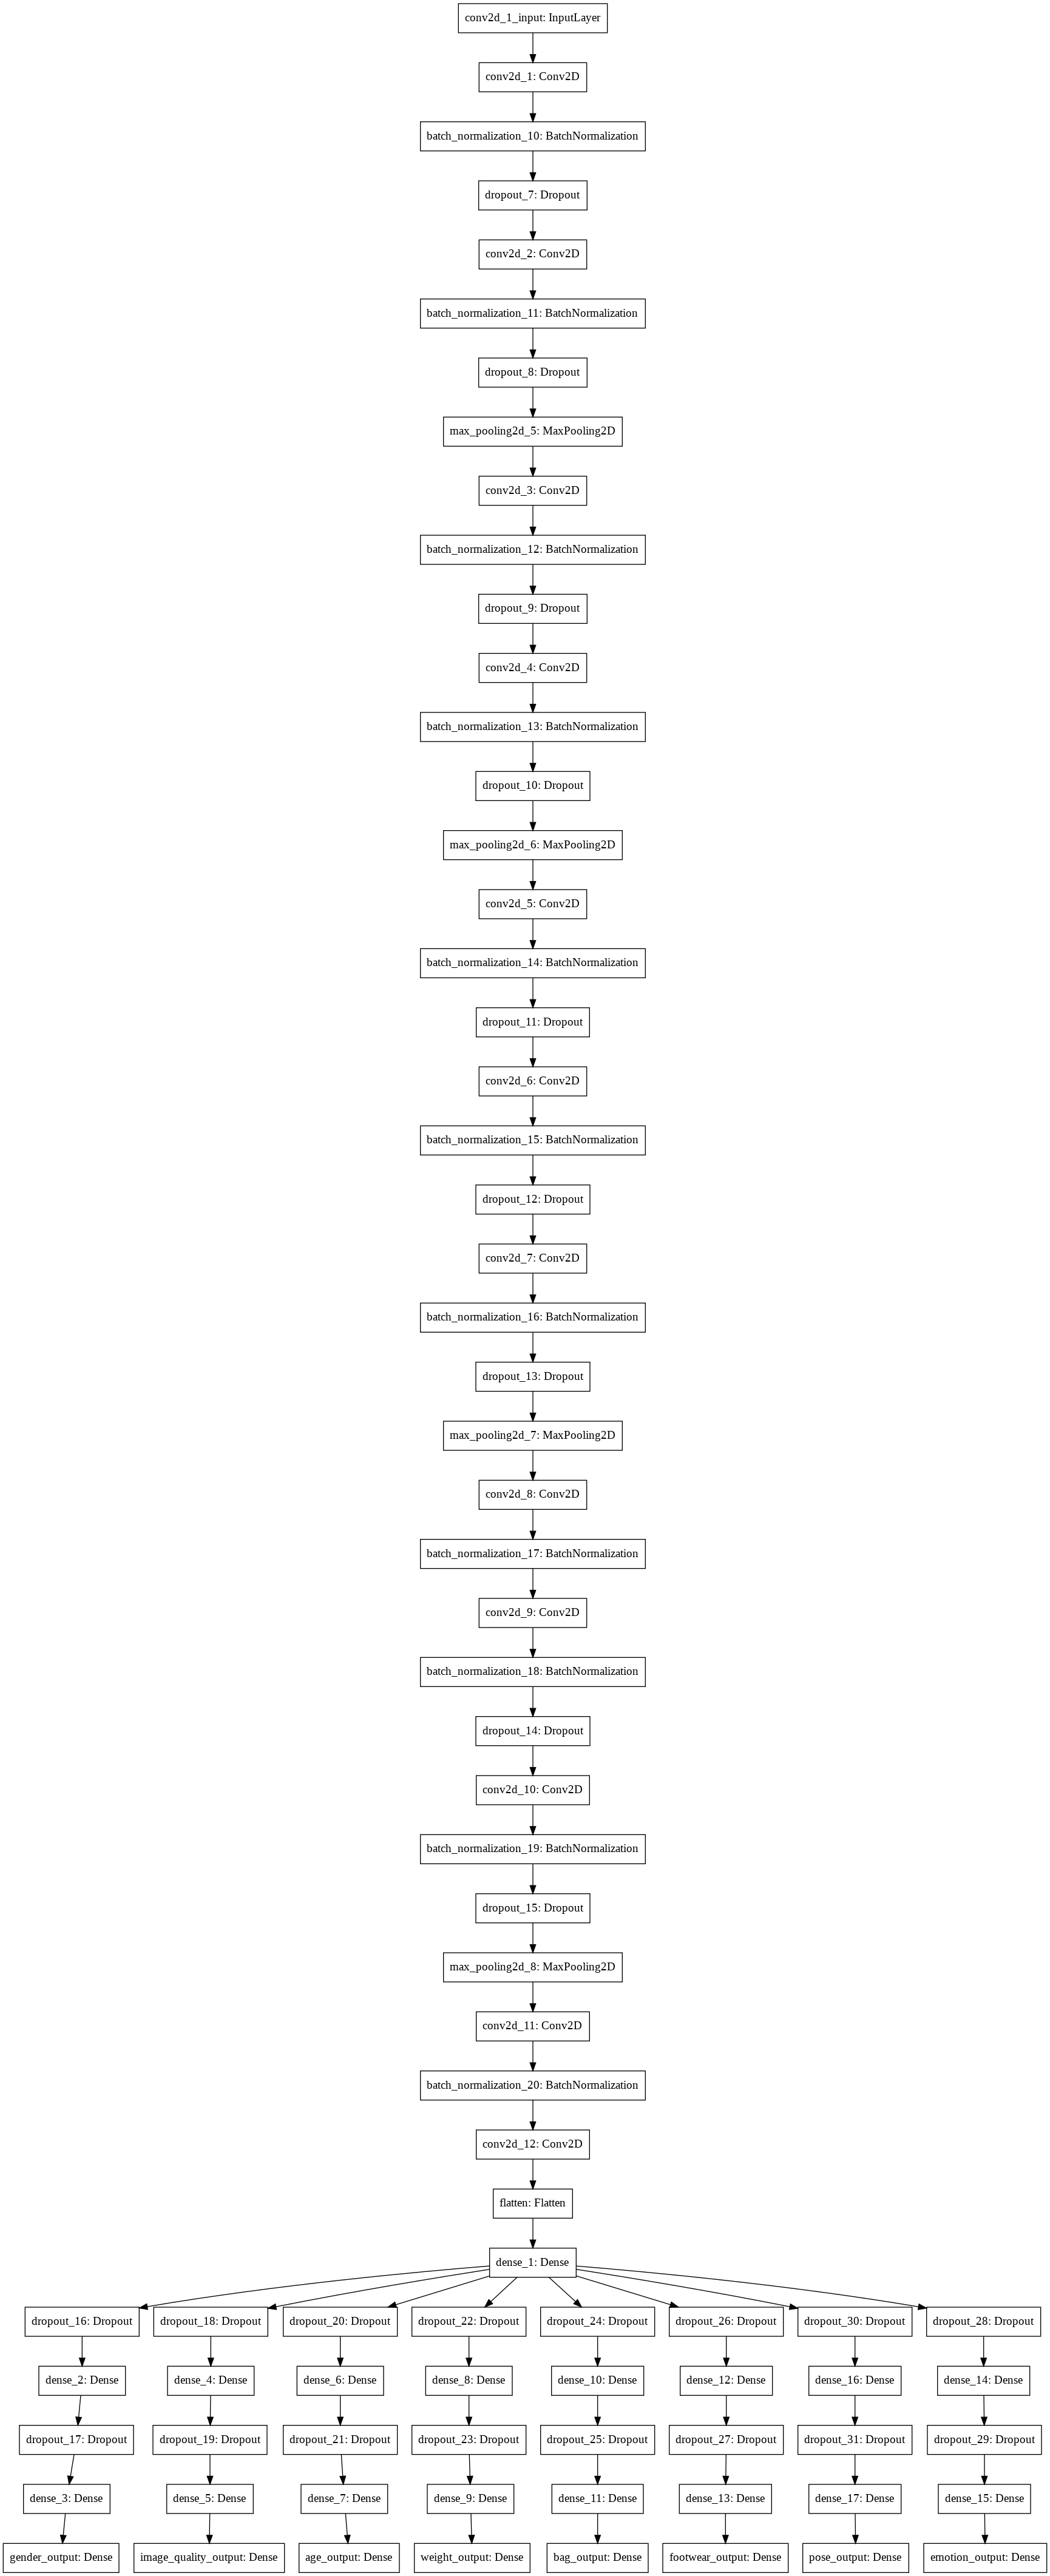

In [0]:
from keras.utils import plot_model
plot_model(model2)

***LR SCHEDULER***

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-2
    if epoch > 80:
        lr *= 1e-2
    elif epoch > 60:
        lr *= 1
    elif epoch > 55:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                              cooldown=0,#
                               patience=5,
                               min_lr=0.5e-6)
callbacks=[lr_scheduler]

***COMPILE AND FIT MODEL (CUSTOM MODEL TRIAL)***

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.01, momentum=0.9)
model2.compile(
    #optimizer=opt,
    optimizer=keras.optimizers.
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
model2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=100,
    verbose=1
    #callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
339/339 [==============================] - 169s 499ms/step - loss: 7.9605 - gender_output_loss: 0.6937 - image_quality_output_loss: 0.9952 - age_output_loss: 1.4454 - weight_output_loss: 0.9965 - bag_output_loss: 0.9273 - footwear_output_loss: 1.0278 - pose_output_loss: 0.9395 - emotion_output_loss: 0.9352 - gender_output_acc: 0.5573 - image_quality_output_acc: 0.5499 - age_output_acc: 0.3926 - weight_output_acc: 0.6374 - bag_output_acc: 0.5589 - footwear_output_acc: 0.4850 - pose_output_acc: 0.6128 - emotion_output_acc: 0.7062 - val_loss: 8.0481 - val_gender_output_loss: 0.6851 - val_image_quality_output_loss: 0.9821 - val_age_output_loss: 1.4706 - val_weight_output_loss: 1.0351 - val_bag_output_loss: 0.9353 - val_footwear_output_loss: 1.0914 - val_pose_output_loss: 0.9173 - val_emotion_output_loss: 0.9312 - val_gender_output_acc: 0.5495 - val_image_quality_output_acc: 0.5502 - 

In [0]:
results = model2.evaluate_generator(valid_gen,verbose=1)
dict(zip(model2.metrics_names,results))

84/84 [==============================] - 29s 347ms/step


{'age_output_acc': 0.38764880952380953,
 'age_output_loss': 1.3999247877370744,
 'bag_output_acc': 0.6000744047619048,
 'bag_output_loss': 0.8945860344739187,
 'emotion_output_acc': 0.7072172619047619,
 'emotion_output_loss': 0.8955246284604073,
 'footwear_output_acc': 0.6015625,
 'footwear_output_loss': 0.8871597051620483,
 'gender_output_acc': 0.7533482142857143,
 'gender_output_loss': 0.5045456822429385,
 'image_quality_output_acc': 0.5487351190476191,
 'image_quality_output_loss': 0.9840448924473354,
 'loss': 7.229524419421241,
 'pose_output_acc': 0.7217261904761905,
 'pose_output_loss': 0.6869065733182997,
 'weight_output_acc': 0.6104910714285714,
 'weight_output_loss': 0.9768321088382176}

***SAVING MODEL TO DRIVE***

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
model2.save('model.h5')
model_file = drive.CreateFile({'title' : 'model.h5'})                      
model_file.SetContentFile('model.h5')                      
model_file.Upload()

In [0]:
# download to google drive                       
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '12oNjcP00gbNQdxetTHNzIWr23ulBeP73'})

***LOADING THE MODEL BACK FROM DRIVE***

In [0]:
file_obj = drive.CreateFile({'id': '12oNjcP00gbNQdxetTHNzIWr23ulBeP73'})                       
file_obj.GetContentFile('keras.h5')

In [0]:
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
modelone = load_model('keras.h5')












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
modelone.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_1_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 32) 864         conv2d_1_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 222, 222, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 222, 222, 32) 0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [0]:
opt = SGD(lr=0.01, momentum=0.9)
modelone.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
modelone.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=100,
    verbose=1
    #callbacks=callbacks
)

Epoch 1/100
360/360 [==============================] - 168s 466ms/step - loss: 6.6539 - gender_output_loss: 0.4153 - image_quality_output_loss: 0.9235 - age_output_loss: 1.3513 - weight_output_loss: 0.9258 - bag_output_loss: 0.8049 - footwear_output_loss: 0.8095 - pose_output_loss: 0.5621 - emotion_output_loss: 0.8616 - gender_output_acc: 0.8151 - image_quality_output_acc: 0.5594 - age_output_acc: 0.4123 - weight_output_acc: 0.6451 - bag_output_acc: 0.6466 - footwear_output_acc: 0.6394 - pose_output_acc: 0.7731 - emotion_output_acc: 0.7115 - val_loss: 6.8496 - val_gender_output_loss: 0.4469 - val_image_quality_output_loss: 0.9353 - val_age_output_loss: 1.3585 - val_weight_output_loss: 0.9099 - val_bag_output_loss: 0.8801 - val_footwear_output_loss: 0.8688 - val_pose_output_loss: 0.5774 - val_emotion_output_loss: 0.8728 - val_gender_output_acc: 0.7887 - val_image_quality_output_acc: 0.5625 - val_age_output_acc: 0.4072 - val_weight_output_acc: 0.6424 - val_bag_output_acc: 0.5977 - val_fo

In [0]:
modelone.save('model2.h5')
model_file = drive.CreateFile({'title' : 'model2.h5'})                      
model_file.SetContentFile('model2.h5')                      
model_file.Upload()

In [0]:
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '11APS8jHzOC5lr3L7oDqXwE966Z3FMJAi'})

***LOADING MODEL BACK FOR SECOND RUN***

In [0]:
file_obj = drive.CreateFile({'id': '11APS8jHzOC5lr3L7oDqXwE966Z3FMJAi'})                       
file_obj.GetContentFile('keras1.h5')

In [0]:
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
modeltwo = load_model('keras1.h5')

In [0]:
loss_weights = {"age_output": 1.0}

opt = SGD(lr=0.01, momentum=0.9)
modeltwo.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    #loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [27]:
modeltwo.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=100,
    verbose=1
    #callbacks=callbacks
)

NameError: ignored

In [0]:
modeltwo.save('model3.h5')
model_file = drive.CreateFile({'title' : 'model3.h5'})                      
model_file.SetContentFile('model3.h5')                      
model_file.Upload()

In [0]:
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '1SsX2mCIdhatW8SiWlIueTXRP9tVfkTap'})

***LOADING model for third run***

In [0]:
file_obj = drive.CreateFile({'id': '1SsX2mCIdhatW8SiWlIueTXRP9tVfkTap'})                       
file_obj.GetContentFile('keras2.h5')

In [0]:
from keras.models import load_model
# Assuming your model includes instance of an "AttentionLayer" class
modelthree = load_model('keras2.h5')

In [0]:
opt = SGD(lr=0.01, momentum=0.9)
modelthree.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [32]:
modelthree.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=70,
    verbose=1
    #callbacks=callbacks
)

Epoch 1/70
360/360 [==============================] - 160s 446ms/step - loss: 7.5126 - gender_output_loss: 0.5706 - image_quality_output_loss: 0.9588 - age_output_loss: 1.4068 - weight_output_loss: 0.9778 - bag_output_loss: 0.8845 - footwear_output_loss: 0.9783 - pose_output_loss: 0.8448 - emotion_output_loss: 0.8909 - gender_output_acc: 0.6928 - image_quality_output_acc: 0.5522 - age_output_acc: 0.4086 - weight_output_acc: 0.6348 - bag_output_acc: 0.5829 - footwear_output_acc: 0.5290 - pose_output_acc: 0.6464 - emotion_output_acc: 0.7155 - val_loss: 6.9907 - val_gender_output_loss: 0.4018 - val_image_quality_output_loss: 0.9176 - val_age_output_loss: 1.3971 - val_weight_output_loss: 0.9450 - val_bag_output_loss: 0.8668 - val_footwear_output_loss: 0.9069 - val_pose_output_loss: 0.6472 - val_emotion_output_loss: 0.9082 - val_gender_output_acc: 0.8348 - val_image_quality_output_acc: 0.5670 - val_age_output_acc: 0.3676 - val_weight_output_acc: 0.6399 - val_bag_output_acc: 0.5600 - val_foo

In [33]:
results = modelthree.evaluate_generator(valid_gen,verbose=1)
dict(zip(modelthree.metrics_names,results))

63/63 [==============================] - 4s 63ms/step


{'age_output_acc': 0.36755952380952384,
 'age_output_loss': 1.3893418179617987,
 'bag_output_acc': 0.6314484126984127,
 'bag_output_loss': 0.8519561461039952,
 'emotion_output_acc': 0.685515873015873,
 'emotion_output_loss': 0.9210359652837118,
 'footwear_output_acc': 0.6195436507936508,
 'footwear_output_loss': 0.8349484810753475,
 'gender_output_acc': 0.7743055555555556,
 'gender_output_loss': 0.48684172497855294,
 'image_quality_output_acc': 0.564484126984127,
 'image_quality_output_loss': 0.9529446741891285,
 'loss': 6.932435474698505,
 'pose_output_acc': 0.7673611111111112,
 'pose_output_loss': 0.5578864372911907,
 'weight_output_acc': 0.6403769841269841,
 'weight_output_loss': 0.9374801601682391}